In [1]:
import numpy as np
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [20]:
# 데이터셋 준비

signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:, None]

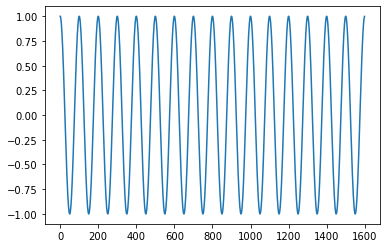

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

In [25]:
# 데이터 분리
train = signal_data[:800]
val = signal_data[800:1200]
test = signal_data[1200:]

In [22]:
#생성한 코사인 데이터를 학습시키기 위해 데이터와 라벨로 구성합니다.
# 이전 수치는 데이터, 다음 수치는 라벨이 됩니다.
# 다른 예제들과는 달리 데이터와 라벨이 모두 같은 속성입니다.

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
look_back = 5

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

In [27]:
# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [28]:
# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

In [29]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 5, 32)                4352      
_________________________________________________________________
dropout_3 (Dropout)          (1, 5, 32)                0         
_________________________________________________________________
lstm_4 (LSTM)                (1, 5, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (1, 5, 32)                0         
_________________________________________________________________
lstm_5 (LSTM)                (1, 32)                   8320      
_________________________________________________________________
dropout_5 (Dropout)          (1, 32)                   0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                   

In [23]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [31]:
# 4. 모델 학습시키기

custom_hist = CustomHistory()
custom_hist.init()

for i in range(20):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False,
              callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
782/795 [============================>.] - ETA: 0s - loss: 0.0814WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002A9984DE4C8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.


In [32]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  0.004815040156245232
Validataion Score:  0.005159068387001753
Test Score:  0.005159068387001753


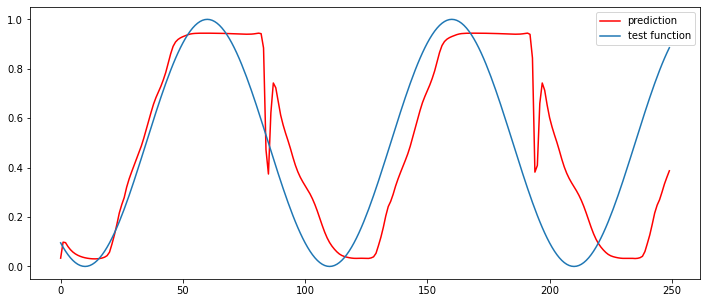

In [18]:
# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

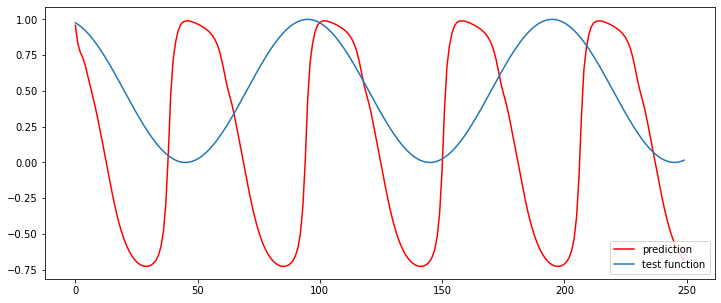

In [39]:
# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

In [37]:
xhat

array([[-0.56223863],
       [-0.60187322],
       [-0.63496679],
       [-0.66216618],
       [-0.68403918]])